# Daily electric consumption prediction with XGBoost

In a previous notebook, we modeled electricity consumption using a Seasonal ARIMA model. With this model, we were able to produce predictions with a mean absolute percentage error of approximately 8%, and a Root Mean Squared Error of 76277 MW. This was an improvement over our baseline of 9% and 83679 MW, which predicted based on a rolling mean calculated over a period of 4 years.

In this notebook, we will use XGBoost (eXtreme Gradient Boosting) to see if we can improve on these predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import RandomizedSearchCV

import holidays
us_holidays = holidays.US()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from Time_series_helpers import param_tracker, plot_feature_importances

## Loading the data: 

The data that we use in this notebook has already been cleaned up in other notebooks to deal with issues like duplicate values arising from time change with dailight saving time, etc... The data was also resampled to switch to daily data, and log-transformed: see the Daily Electric Consumption Analysis and Forecasting notebook for more details.

In [4]:
daily_elec = pd.read_csv('data/processed/daily_elec.csv', index_col=[0], parse_dates=True)

## Encoding Features

Working with xgboost rather than ARIMA means that we should encode as many features as possible into the model to enable it to learn the patterns associated with different time values, as xgboost is not an auto-regressive model which predicts based on its previous values like ARIMA, but a boosted tree-based model.


In [5]:
dx = daily_elec.index
daily_elec['date'] = dx.date
daily_elec['day_num'] = dx.dayofyear
daily_elec['month'] = dx.month
daily_elec['year'] = dx.year
daily_elec['wday'] = dx.dayofweek
daily_elec['yweek'] = dx.weekofyear
daily_elec['quarter'] = dx.quarter

In [6]:
daily_elec.head(14)

,PJME_MW,log_electric_consumption,date,day_num,month,year,wday,yweek,quarter
Datetime,,,,,,,,,
2002-01-01,714857.0,13.479838,2002-01-01,1,1,2002,1,1,1
2002-01-02,822277.0,13.619833,2002-01-02,2,1,2002,2,1,1
2002-01-03,828285.0,13.627113,2002-01-03,3,1,2002,3,1,1
2002-01-04,809171.0,13.603766,2002-01-04,4,1,2002,4,1,1
2002-01-05,729723.0,13.500420,2002-01-05,5,1,2002,5,1,1
2002-01-06,727766.0,13.497735,2002-01-06,6,1,2002,6,1,1
2002-01-07,800012.0,13.592382,2002-01-07,7,1,2002,0,2,1
2002-01-08,824710.0,13.622787,2002-01-08,8,1,2002,1,2,1
2002-01-09,810628.0,13.605565,2002-01-09,9,1,2002,2,2,1


### Adding holidays as features

Here we encode public holidays as features. Since the days before and after public holidays may also be affected by the holidays, we also encode these. The tree based structure of XGboost means that it should be able to differentiate between holidays that are more or less important, for example by using holidays as a separation criteria within a certain month or range of months.

In [7]:
delta = pd.Timedelta('1 day')

daily_elec['holiday'] = daily_elec.date.apply(lambda d: d in us_holidays)
daily_elec['before_hol'] = daily_elec.date.apply(lambda d: d+delta in us_holidays)
daily_elec['after_hol'] = daily_elec.date.apply(lambda d: d-delta in us_holidays)

In [8]:
daily_elec.head(14)

,PJME_MW,log_electric_consumption,date,day_num,month,year,wday,yweek,quarter,holiday,before_hol,after_hol
Datetime,,,,,,,,,,,,
2002-01-01,714857.0,13.479838,2002-01-01,1,1,2002,1,1,1,True,False,False
2002-01-02,822277.0,13.619833,2002-01-02,2,1,2002,2,1,1,False,False,True
2002-01-03,828285.0,13.627113,2002-01-03,3,1,2002,3,1,1,False,False,False
2002-01-04,809171.0,13.603766,2002-01-04,4,1,2002,4,1,1,False,False,False
2002-01-05,729723.0,13.500420,2002-01-05,5,1,2002,5,1,1,False,False,False
2002-01-06,727766.0,13.497735,2002-01-06,6,1,2002,6,1,1,False,False,False
2002-01-07,800012.0,13.592382,2002-01-07,7,1,2002,0,2,1,False,False,False
2002-01-08,824710.0,13.622787,2002-01-08,8,1,2002,1,2,1,False,False,False
2002-01-09,810628.0,13.605565,2002-01-09,9,1,2002,2,2,1,False,False,False


## Splitting the data into a trend, training and test set

In [9]:
full_day_data = daily_elec.copy()
trend, train, test = full_day_data[(full_day_data.index < '2006')], \
full_day_data[(full_day_data.index >= '2006')& (full_day_data.index < '2016')] , \
full_day_data[(full_day_data.index >= '2016') & (full_day_data.index < '2018')]

In [10]:
X_train, y_train = train.drop(['PJME_MW', 'log_electric_consumption', 'date'], axis = 'columns'), \
train['log_electric_consumption']

X_test, y_test = test.drop(['PJME_MW', 'log_electric_consumption', 'date'], axis = 'columns'), \
test['log_electric_consumption']

## Training a first, untuned model

In [11]:
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror')

In [12]:
xgb_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], early_stopping_rounds = 10, verbose = True)

[0]	validation_0-rmse:9.13680	validation_1-rmse:9.09559
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:6.39730	validation_1-rmse:6.35616
[2]	validation_0-rmse:4.47977	validation_1-rmse:4.43872
[3]	validation_0-rmse:3.13781	validation_1-rmse:3.09692
[4]	validation_0-rmse:2.19903	validation_1-rmse:2.15836
[5]	validation_0-rmse:1.54222	validation_1-rmse:1.50218
[6]	validation_0-rmse:1.08243	validation_1-rmse:1.04289
[7]	validation_0-rmse:0.76154	validation_1-rmse:0.72296
[8]	validation_0-rmse:0.53721	validation_1-rmse:0.50463
[9]	validation_0-rmse:0.38126	validation_1-rmse:0.35633
[10]	validation_0-rmse:0.27342	validation_1-rmse:0.25534
[11]	validation_0-rmse:0.19942	validation_1-rmse:0.18823
[12]	validation_0-rmse:0.14916	validation_1-rmse:0.15025
[13]	validation_0-rmse:0.11653	validation_1-rmse:0.12756
[14]	validation_0-rmse:0.09610	validation_1-rmse:0.11

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [13]:
xgb_preds = xgb_reg.predict(X_test)

### Visualizing predictions of the untuned model

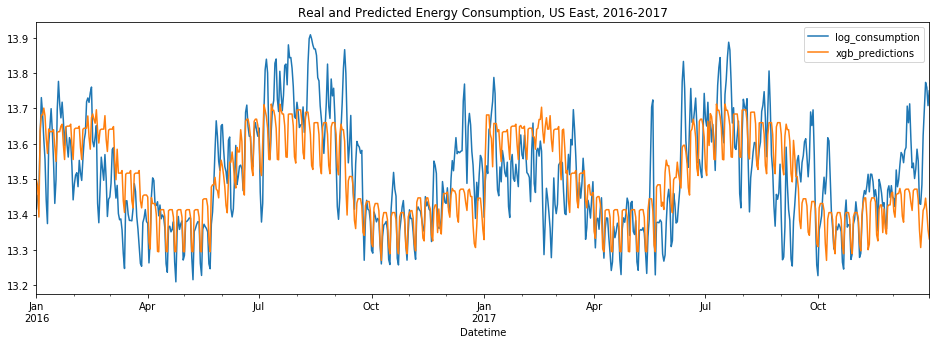

In [14]:
validation_df = pd.DataFrame({'log_consumption':y_test, 'xgb_predictions':xgb_preds}, index = y_test.index)

validation_df.plot(figsize=(16,5), title = 'Real and Predicted Energy Consumption, US East, 2016-2017')

The plot of our model's predictions shows that our model seems to be  underfitting rather than overfitting. 
While it has picked up the weekly trends and the general trend of more electricity consumption in the winter and in the summer, predictions are flat for each quarter, basically, and the model doesn't seem to have identified the need to increase predictions in December.  
In order to improve the model, we need to add features, use a slower learning rate, and possibly deeper trees.  
Note that for an XGBoost model, we should not be too worried about creating a model that overfits, as we can add regularization hyper-parameters later on to reduce the overfitting.

### Looking at the metrics of the  untuned model

In [15]:
validation_df['real_elec_consumption_MW'] = validation_df.log_consumption.apply(np.exp)
validation_df['xgb_pred_MW'] = validation_df.xgb_predictions.apply(np.exp)

np.sqrt(mse(validation_df['real_elec_consumption_MW'], validation_df['xgb_pred_MW']))

89650.40750045291

Our XGBoost predictions are not only off by more than SARIMA predictions, they are off by more than our very simple baseline model which was just a rolling mean of the first 4 years of data. This suggests that our XGBoost model is not managing to even calculate these values, and that we should manually engineer more features before tuning it.
In the previous notebook, we used the first 4 years to gather a lot of trend information. We'll use them again to add features to the XGBoost model.

## Engineering additional features for the XGBoost model

Below we engineer 6 new features that could be useful for our XGBoost model to better capture the expected seasonality of the data. These features are the mean of the  rolling mean, max and min values for the day over periods of one week and four weeks, centered on the day for which we want to make a prediction.

In [16]:
#gathering rolling statistics
trend['week_roll_mean'] = trend.rolling(window=7, center=True).log_electric_consumption.mean()
trend['fourw_roll_mean'] = trend.rolling(window=28, center=True).log_electric_consumption.mean()
trend['week_roll_max'] = trend.rolling(window=7, center=True).log_electric_consumption.max()
trend['fourw_roll_max'] = trend.rolling(window=28, center=True).log_electric_consumption.max()
trend['week_roll_min'] = trend.rolling(window=7, center=True).log_electric_consumption.min()
trend['fourw_roll_min'] = trend.rolling(window=28, center=True).log_electric_consumption.min()

#turning these rolling statistics into variables linked to days
singleweek_day_trend = trend.groupby('day_num').week_roll_mean.mean()
fourweek_day_trend = trend.groupby('day_num').fourw_roll_mean.mean()
week_roll_max = trend.groupby('day_num').week_roll_max.mean()
fourw_roll_max = trend.groupby('day_num').fourw_roll_max.mean()
week_roll_min = trend.groupby('day_num').week_roll_min.mean()
fourw_roll_min = trend.groupby('day_num').fourw_roll_min.mean()
day_features = pd.concat([singleweek_day_trend, fourweek_day_trend, week_roll_max, fourw_roll_max, week_roll_min, fourw_roll_min],
                        axis=1)
#visualizing the data
day_features

,week_roll_mean,fourw_roll_mean,week_roll_max,fourw_roll_max,week_roll_min,fourw_roll_min
day_num,,,,,,
1,13.489577,13.561803,13.586128,13.737163,13.379467,13.379467
2,13.490776,13.563140,13.573933,13.745574,13.379467,13.379467
3,13.499501,13.566296,13.607194,13.772442,13.379467,13.379467
4,13.532251,13.567962,13.649101,13.751325,13.404560,13.379467
5,13.560234,13.571149,13.649101,13.769264,13.457679,13.379467
...,...,...,...,...,...,...
362,13.539529,13.560087,13.606035,13.736221,13.475885,13.379467
363,13.531702,13.561940,13.610842,13.736221,13.427459,13.379467
364,13.520916,13.562973,13.610842,13.736221,13.393005,13.379467


In [17]:
train_wfeatures = pd.merge(train, day_features, how = 'left', left_on = 'day_num', right_on = day_features.index)

In [18]:
train_wfeatures.head()

,PJME_MW,log_electric_consumption,date,day_num,month,year,wday,yweek,quarter,holiday,before_hol,after_hol,week_roll_mean,fourw_roll_mean,week_roll_max,fourw_roll_max,week_roll_min,fourw_roll_min
0,709984.0,13.472998,2006-01-01,1,1,2006,6,52,1,True,True,False,13.489577,13.561803,13.586128,13.737163,13.379467,13.379467
1,769220.0,13.553132,2006-01-02,2,1,2006,0,1,1,True,False,True,13.490776,13.563140,13.573933,13.745574,13.379467,13.379467
2,818656.0,13.615419,2006-01-03,3,1,2006,1,1,1,False,False,True,13.499501,13.566296,13.607194,13.772442,13.379467,13.379467
3,822402.0,13.619985,2006-01-04,4,1,2006,2,1,1,False,False,False,13.532251,13.567962,13.649101,13.751325,13.404560,13.379467
4,796940.0,13.588535,2006-01-05,5,1,2006,3,1,1,False,False,False,13.560234,13.571149,13.649101,13.769264,13.457679,13.379467


In [19]:
test_wfeatures = pd.merge(test, day_features, how = 'left', left_on = 'day_num', right_on = day_features.index)

In [20]:
X_train_wf, y_train_wf = train_wfeatures.drop(['PJME_MW', 'log_electric_consumption', 'date'], axis = 'columns'), \
train_wfeatures['log_electric_consumption']

X_test_wf, y_test_wf = test_wfeatures.drop(['PJME_MW', 'log_electric_consumption', 'date'], axis = 'columns'), \
test['log_electric_consumption']

## Testing an untuned XGBoost model on this new, feature rich data

In [21]:
xgb2_reg = xgb.XGBRegressor(objective = 'reg:squarederror', learning_rate = .1)
xgb2_reg.fit(X_train_wf, y_train_wf, 
             eval_set = [(X_train_wf, y_train_wf), (X_test_wf, y_test_wf)], 
             early_stopping_rounds = 10, verbose = True)

[0]	validation_0-rmse:11.74575	validation_1-rmse:11.70450
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:10.57167	validation_1-rmse:10.53044
[2]	validation_0-rmse:9.51499	validation_1-rmse:9.47378
[3]	validation_0-rmse:8.56397	validation_1-rmse:8.52277
[4]	validation_0-rmse:7.70805	validation_1-rmse:7.66687
[5]	validation_0-rmse:6.93773	validation_1-rmse:6.89657
[6]	validation_0-rmse:6.24445	validation_1-rmse:6.20331
[7]	validation_0-rmse:5.62051	validation_1-rmse:5.57940
[8]	validation_0-rmse:5.05898	validation_1-rmse:5.01790
[9]	validation_0-rmse:4.55362	validation_1-rmse:4.51255
[10]	validation_0-rmse:4.09879	validation_1-rmse:4.05773
[11]	validation_0-rmse:3.68944	validation_1-rmse:3.64840
[12]	validation_0-rmse:3.32103	validation_1-rmse:3.28001
[13]	validation_0-rmse:2.98948	validation_1-rmse:2.94848
[14]	validation_0-rmse:2.69110	validation_1-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Despite the features that we have added, we still get a validation root mean squared error of almost .0108. Let's convert this back to the original units to see what this corresponds to in MW per day.

In [22]:
xgb2_preds = xgb2_reg.predict(X_test_wf)
validation_df['xgb2_predictions'] = xgb2_preds
validation_df['xgb2_pred_MW'] = validation_df.xgb2_predictions.apply(np.exp)

np.sqrt(mse(validation_df['real_elec_consumption_MW'], validation_df['xgb2_pred_MW']))

84414.45700529712

Predictions are still slightly worse than the baseline; this suggests that XGBoost is not tuned correctly

## Tuning XGBoost parameters for better predictions

As you can see below, XGBoost has many parameters which can be tuned. There are far too many to use a method like grid search, as trying just 4 parameter values for 5 different parameters would require 4 to the 5th power combinations, or over 1000 runs of the XGBoost algorithm. Therefore, we will tune manually, using a learning rate of 0.05.
As we get the results for each parameter, we keep the best parameters yet and tune additional parameters.

In [23]:
xgb_reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### Parameters which we will look at in tuning:

There are two main types of parameters which we will tune: tree parameters control how trees are built, and regularization parameters control either how gain is calculated or how trees are pruned.
- tree parameters: max_depth, subsample, colsample by tree
- regularization parameters: gamma, reg lambda

In order to tune, we created a class with an object to keep track of the parameters which have worked best for now, with methods so that the object updates when it finds parameters that work better than its previous best parameters.

#### Tuning tree parameters

Note that some parameters are already set: 
- learning rate is set to a standard value, which is low enough to give the algorithm time to find all of the characteristics of the data and high enough to be fast.
- Verbosity set to 0 as our unconventional way of searching for best parameters leads to useless warnings from xgboost
- the 999 value for n_estimators doesn't mean that XGboost will fit that many trees, since early stopping is on, but it prevents XGBoost from underfitting, because the learning rate is too low to use the default value of 100 trees.

In [24]:
xgb3_reg = xgb.XGBRegressor(learning_rate = .05, n_estimators = 999, random_state = 27314, verbosity = 0) 

pt = param_tracker(xgb3_reg, X_train_wf, y_train_wf, X_test_wf, y_test_wf)
pt.test_params('max_depth', [2, 3, 4, 5, 7])

results for max_depth of 2: rmse 0.097657
updated parameters: new best score = 0.097657
results for max_depth of 3: rmse 0.099614
results for max_depth of 4: rmse 0.102642
results for max_depth of 5: rmse 0.104399
results for max_depth of 7: rmse 0.109713


Adding depth to trees seems to make results worse. So we continue with a max depth of 2.

In [25]:
pt.test_params('subsample', [0.7, 0.8, 0.9, 1])

results for subsample of 0.7: rmse 0.098078
results for subsample of 0.8: rmse 0.098026
results for subsample of 0.9: rmse 0.097878
results for subsample of 1: rmse 0.097657


We got our best results with all of the data.

In [26]:
pt.test_params('colsample_bytree', [0.2, 0.3, 0.5, 0.7, 0.9, 1])

results for colsample_bytree of 0.2: rmse 0.097336
updated parameters: new best score = 0.097336
results for colsample_bytree of 0.3: rmse 0.096994
updated parameters: new best score = 0.096994
results for colsample_bytree of 0.5: rmse 0.097815
results for colsample_bytree of 0.7: rmse 0.097933
results for colsample_bytree of 0.9: rmse 0.097842
results for colsample_bytree of 1: rmse 0.097657


Using a very low portion of the columns (20%) in each tree seems to be leading to improvements in the model. 

#### Regularization parameters

Now we look at gamma regularization. Gamma regularization prunes trees if the gain associated with building a particular branch is lower than the value of gamma. The pruning starts from the bottom of the tree and moves its way up until the gain associated with splitting a node into two branches becomes higher than gamma.

In [27]:
pt.test_params('gamma', [0, 0.1, 0.2, 0.4, 0.7, 1, 2])

results for gamma of 0: rmse 0.096994
results for gamma of 0.1: rmse 0.097096
results for gamma of 0.2: rmse 0.097704
results for gamma of 0.4: rmse 0.098254
results for gamma of 0.7: rmse 0.099226
results for gamma of 1: rmse 0.099959
results for gamma of 2: rmse 0.103448


Gamma regularization (or rather, gamma pruning) was harmful for the model. Our final attempt to improve the model is with a lambda regularization. 

The lambda term is a value which is added to the denominator in the calculation of the similarity scores of branches. A high lambda therefore decreases gain, which is what XGboost calculates to determine whether it should continue splitting the data. Since the original value of the denominator is the number of samples which go into the leaf, lambda regularization has more impact on leaves with small amounts of data. Basically, high lambda values reduce the sensitivity of the model to isolated observations.

By default the lambda value which is used is 1.

In [28]:
pt.test_params('reg_lambda', [0, 0.5, 1, 1.5, 2, 4])

results for reg_lambda of 0: rmse 0.097036
results for reg_lambda of 0.5: rmse 0.097009
results for reg_lambda of 1: rmse 0.096994
results for reg_lambda of 1.5: rmse 0.097436
results for reg_lambda of 2: rmse 0.097683
results for reg_lambda of 4: rmse 0.098045


### Fitting the final XGBoost model with tuned parameters 

In [29]:
xgb_tuned = xgb.XGBRegressor(**pt.params)
xgb_tuned.fit(X_train_wf, y_train_wf, eval_set = [(X_train_wf, y_train_wf), (X_test_wf, y_test_wf)], 
                     early_stopping_rounds = 10)

[0]	validation_0-rmse:12.39800	validation_1-rmse:12.35675
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:11.77835	validation_1-rmse:11.73711
[2]	validation_0-rmse:11.18968	validation_1-rmse:11.14844
[3]	validation_0-rmse:10.63044	validation_1-rmse:10.58921
[4]	validation_0-rmse:10.09916	validation_1-rmse:10.05794
[5]	validation_0-rmse:9.59444	validation_1-rmse:9.55322
[6]	validation_0-rmse:9.11496	validation_1-rmse:9.07375
[7]	validation_0-rmse:8.65944	validation_1-rmse:8.61824
[8]	validation_0-rmse:8.22671	validation_1-rmse:8.18552
[9]	validation_0-rmse:7.81561	validation_1-rmse:7.77443
[10]	validation_0-rmse:7.42507	validation_1-rmse:7.38389
[11]	validation_0-rmse:7.05405	validation_1-rmse:7.01289
[12]	validation_0-rmse:6.70159	validation_1-rmse:6.66044
[13]	validation_0-rmse:6.36675	validation_1-rmse:6.32561
[14]	validation_0-rmse:6.04866	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=999, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=27314, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

### Plotting predictions

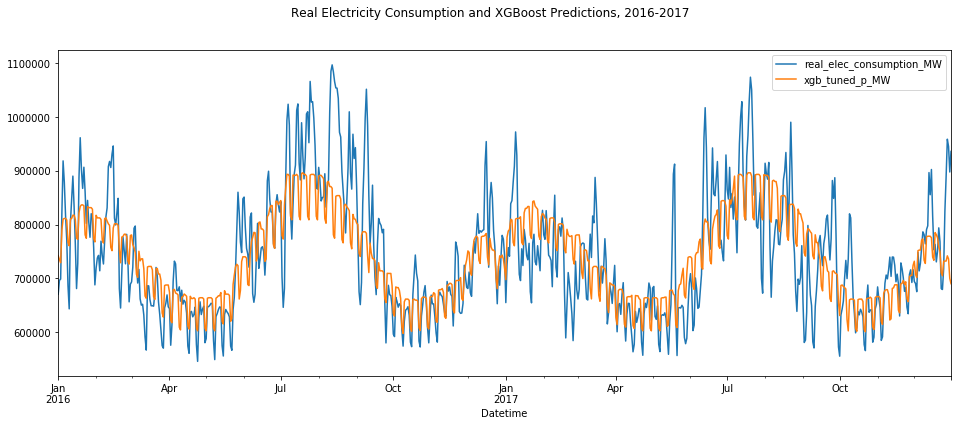

In [30]:
xgbt_preds = xgb_tuned.predict(X_test_wf)

validation_df['xgb_tuned_preds'] = xgbt_preds
validation_df['xgb_tuned_p_MW'] = validation_df.xgb_tuned_preds.apply(np.exp)

fig = validation_df.loc[:,['real_elec_consumption_MW', 'xgb_tuned_p_MW']].plot(figsize = (16,6)).get_figure()
fig.suptitle('Real Electricity Consumption and XGBoost Predictions, 2016-2017')
fig.savefig('xgb_preds_noweather.png')

We can see on the plot that tuning the XGBoost parameters has clearly led to better predictions. While a few spikes in summer 2016 were not anticipated by the model, the general trend of the data seems to have been well captured.
Notice that the model also changes the amplitude of its weekday to weekend variations depending on whether we are in summer or in other seasons. This reflects something that we can see in the real data, but that the SARIMA model could not model.

In [31]:
np.sqrt(mse(validation_df['real_elec_consumption_MW'], validation_df['xgb_tuned_p_MW']))

76230.8492151256

The RMSE has been reduced, however predictions are still a little bit worse than what we had with seasonal Arima. 
So even though XGBoost has the advantage of being able to incorporate holidays, and was fed a lot more data in the form of features, it did not out-perform seasonal ARIMA, which is a simpler algorithm but which is specifically designed for time series. 

However, RMSE is not the only metric we are interested in. We should also compare the MAPE of both predictions. Note that just like for the SARIMA predictions, we are not looking at the real MAPE, but its approximation, the MAE of the logged data. However, for errors below 10%, this approximation is reliable.


In [32]:
mae(validation_df['log_consumption'], validation_df['xgb_tuned_preds'])

0.07533948298396767

Interestingly, the MAPE of the XGBoost model is lower than the MAPE of the SARIMA model, which was .078. This suggests that the XGBoost predictions were generally closer, but that they made a few large errors for which the SARIMA model was closer to the truth.

## Graphing XGBoost and Sarima predictions together to compare them

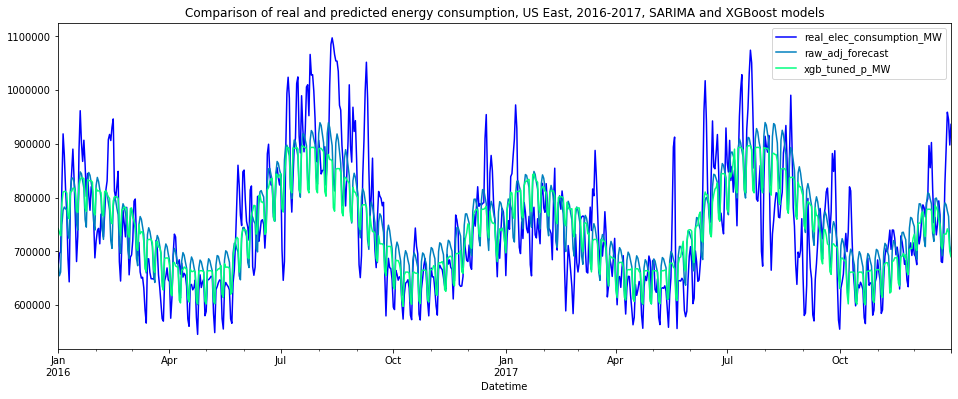

In [33]:
Sarima_preds = pd.read_csv('data/processed/Sarima_predictions.csv', index_col=[0], parse_dates=True)

all_preds = pd.concat([validation_df['real_elec_consumption_MW'], Sarima_preds, validation_df['xgb_tuned_p_MW']], axis=1)

all_preds.plot(figsize=(16,6), colormap = 'winter', 
               title = 'Comparison of real and predicted energy consumption, US East, 2016-2017, SARIMA and XGBoost models')

As we can see above, XGBoost and Sarima predictions are very similar, and overlap quite closely: this indicates that for the most part, whatever residual errors remain are things that could not be fully predicted by a forecasting model.
Generally, the Sarima model predictions, in green, seem to hav higher weekly amplitude.  

The lower RMSE of the Sarima model is probably due to the fact that SARIMA predictions are higher than XGBoost predictions for August 2016, which saw the highest levels of electricity consumption in the period, probably due to extreme heat during that summer.  

On the other hand, the lower MAPE of the XGBoost model is probably due to its predictions being closer to the truth for months like April and October for which the SARIMA model seems to consistently produce predictions that are slightly too high.

## Looking at XGBoost feature importances

In [34]:
plot_feature_importances(xgb_tuned, X_train_wf, title = 'Plot of XGBoost Feature Importances')

TypeError: plot_feature_importances() got an unexpected keyword argument 'title'

While the day of the week was one of the most important features in the XGBoost model, all of the  other features that we engineered based on the first 4 years of data were very important also. Interestingly, some rolling maximum and minimum values were more important than rolling mean values for the model.

We can see also that the number of the day in the year was still used a bit to build trees even though it has been used so often in the features.  
The year variable plays a small role, which means xgboost might have spotted some sort of long term trend or interaction, and the month and week variables also play a small role.  

Holidays also played a small role, but for a day to be before or after a holiday had almost no impact.